In [9]:
import json
import pandas as pd
import numpy as np
import gcsfs
import warnings
import requests
from PIL import Image
from io import BytesIO

This notebook assumes you already have a local server deployed and running + that you already ingested the products using a data loader.

### Utils

#### Defs

In [59]:
BASE_SL_URL = f"http://localhost:8080"
SL_API_MAP = {
    'ingest_event': f"{BASE_SL_URL}/api/v1/ingest/event_schema",
    'ingest_product': f"{BASE_SL_URL}/api/v1/ingest/product_schema",
    'ingest_user': f"{BASE_SL_URL}/api/v1/ingest/user_schema",
    'item2item': f"{BASE_SL_URL}/api/v1/search/item_2item",
    'user2item': f"{BASE_SL_URL}/api/v1/search/user_2item",
    'data_loader_run': f"{BASE_SL_URL}/data_loader/product_schema/run",
    'popularity': f"{BASE_SL_URL}/api/v1/search/item_popularity"
}

params = {
    "user": {
      "query": "user2item_query",
      "params": {
        "topic_weight": 0.5,
        "brand_weight": 0.5,
        "product_type_weight": 0.5,
        "item2vec_weight": 1,
        "image_weight": 1
      }
    },
    "item_similarity": {
      "query": "item2item_query",
      "params": {
        "topic_weight": 0.5,
        "brand_weight": 0.5,
        "product_type_weight": 0.5,
        "popularity_weight": 0.5,
        "item2vec_weight": 1,
        "image_weight": 1
      }
    },
    "item_complementary_topic": {
      "query": "item2item_query",
      "params": {
        "topic_weight": -1,
        "brand_weight": 0,
        "product_type_weight": 0,
        "popularity_weight": 0,
        "item2vec_weight": 1,
        "image_weight": 0
      }
    },
    "item_complementary_type": {
      "query": "item2item_query",
      "params": {
        "topic_weight": 0,
        "brand_weight": 0,
        "product_type_weight": -1,
        "popularity_weight": 0,
        "item2vec_weight": 1,
        "image_weight": 0
      }
    }
  }

#### Util functions

In [11]:
def show_image_from_ulr(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    ## resize
    img = img.resize((200, 200))
    img.show()

#### Data sample

In [15]:
## read data
products_df = pd.read_json("gs://ecommerce-recipe/data/source/active_products_cleaned.jsonl", lines=True)
events_df = pd.read_json("gs://ecommerce-recipe/data/source/full_events.json", lines=True, orient='records', nrows=1000)
events_df["created_at"] = pd.to_datetime(events_df["created_at"]).astype(int) // 10**9
events_df_sample = pd.merge(events_df, products_df[['id']].rename(columns={'id':'product'}), on='product')
product_id_to_url = products_df.set_index('id')['product_image'].to_dict()

In [62]:
products_df.sample(3)

,id,is_active,product_image,description,topic,brand,product_type,popularity,item_w2v
4003,18367282,1,https://media.brandalley.co.uk/catalog/product...,</ul><li>Skinny Fit </li><li>Digital Print </l...,female_clothing,schöffel,blouses_&_tops,0.014594,"[-0.0295987334, 0.0509994365, 0.05589350310000..."
5391,18514055,1,https://media.brandalley.co.uk/catalog/product...,<ul><li>Skimpy Coverage Pant</li><li>High Legl...,female_lingerie,seafolly,swimwear_&_beachwear,0.219382,"[0.2209667712, -0.0100667551, 0.0872854814, 0...."
6999,18624345,1,https://media.brandalley.co.uk/catalog/product...,<ul><li>Button Fastening</li><li>Tassel Trim</...,female_clothing,max&co.,skirts,0.030888,"[0.0880238414, 0.0031594697, 0.0866308212, 0.0..."


In [18]:
events_df_sample.head()

,user,session_id,product,event_type,created_at
0,2391885,1718520365363,18888360,product_viewed,1718520414
1,2097335,1724517034717,18881606,product_viewed,1724517252
2,5175921,1727358678655,18666010,product_viewed,1727358757
3,7945238,1724388522593,18331052,product_viewed,1724388719
4,12614649,1724712719694,18112549,product_viewed,1724712956


## Item2Item

This will be our query item for the examples below.

Here you can change the weight parameters in the object defined at the start of this notebook to see how this is affect recommendations.

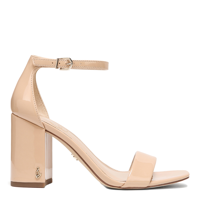

In [27]:
item = "18842712" ## female trouses
show_image_from_ulr(product_id_to_url[int(item)])

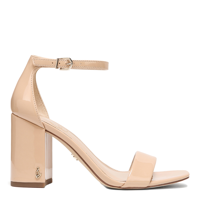

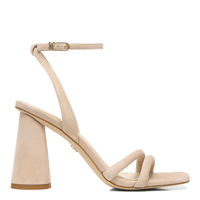

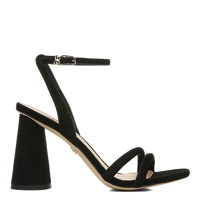

In [28]:
## simialr items 
similar_query_data = params['item_similarity']['params']
similar_query_data['product_id'] = item
similar_query_data['limit'] = 3
response = requests.post(SL_API_MAP['item2item'], json=similar_query_data)
response_json = response.json()
neighbors = [i['entity']['id'] for i in response_json['results']]
for i in neighbors:
    show_image_from_ulr(product_id_to_url[int(i)])

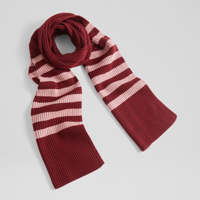

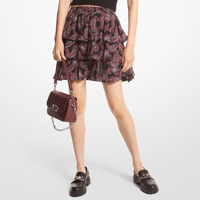

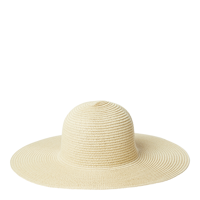

In [32]:
import random
## complementary items 
similar_query_data = params['item_complementary_topic']['params']
similar_query_data['product_id'] = item
similar_query_data['limit'] = 10
response = requests.post(SL_API_MAP['item2item'], json=similar_query_data)
response_json = response.json()
neighbors = [i['entity']['id'] for i in response_json['results']]
random.shuffle(neighbors)
for i in neighbors[:3]:
    show_image_from_ulr(product_id_to_url[int(i)])

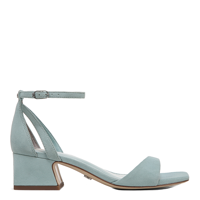

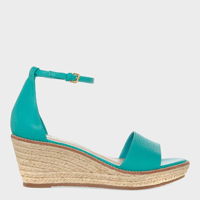

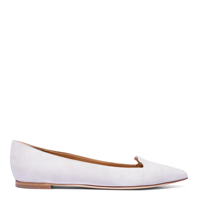

In [33]:
## complementary items 
import random
similar_query_data = params['item_complementary_type']['params']
similar_query_data['product_id'] = item
similar_query_data['limit'] = 10
response = requests.post(SL_API_MAP['item2item'], json=similar_query_data)
response_json = response.json()
neighbors = [i['entity']['id'] for i in response_json['results']]
random.shuffle(neighbors)
for i in neighbors[:3]:
    show_image_from_ulr(product_id_to_url[int(i)])

## Popularity

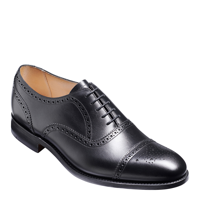

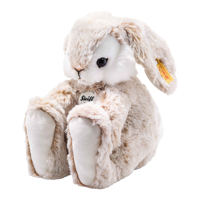

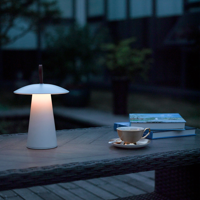

In [34]:
## complementary items 
import random
response = requests.post(SL_API_MAP['popularity'], json={'limit': 10})
response_json = response.json()
neighbors = [i['entity']['id'] for i in response_json['results']]
random.shuffle(neighbors)
for i in neighbors[:3]:
    show_image_from_ulr(product_id_to_url[int(i)])

## User2Item

### Ingest event for user

In [50]:
def get_user_dummy_vector(user_id):
    """Creates a dummy user vector."""
    return {
        "id": user_id,
        "user_topic": "",
        "user_brand": "",
        "user_product_type": "",
        "user_item_w2v": [0.0] * 100,
        "user_image": "https://media.brandalley.co.uk/catalog/product/1/8/18857322-1.jpg" ## dummy image
    }

In [55]:
## we will create dummpy user journey with the top 100 events from sample.
batch_events = events_df_sample.sort_values('created_at', ascending=True)[['user', 'product', 'event_type', 'created_at']].sample(20).reset_index(drop=True)
batch_events['id'] = range(1, len(batch_events)+1)
batch_events['user'] = 'test_123'
batch_events = batch_events.to_dict(orient='records')

In [56]:
## before ingesting events we need to create user schema and ingest user
user_data = get_user_dummy_vector('test_123')
response = requests.post(SL_API_MAP['ingest_user'], json=user_data)

In [57]:
## ingest events
for event in batch_events:
    response = requests.post(SL_API_MAP['ingest_event'], json=event)
    ## check response code to make sure event is ingested successfully
    if response.status_code >= 300:
        print(f"Error in ingesting event: {event}")


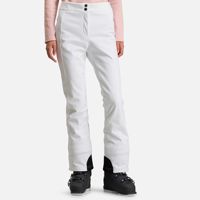

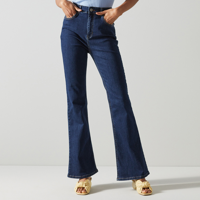

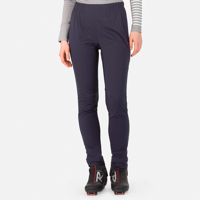

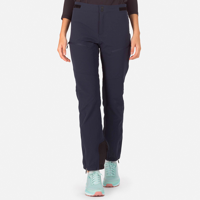

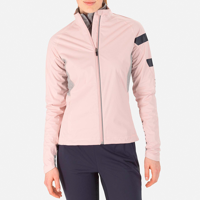

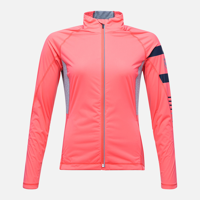

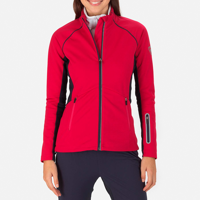

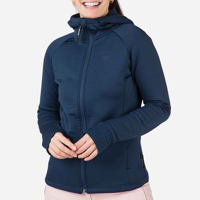

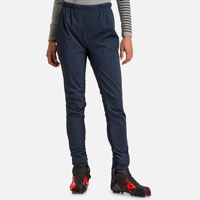

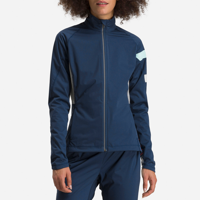

In [61]:
## get recommendations for user
import random
user_query_data = params['user']['params']
user_query_data['user_id'] = 'test_123'
user_query_data['limit'] = 10
response = requests.post(SL_API_MAP['user2item'], json=user_query_data)
response_json = response.json()
neighbors = [i['entity']['id'] for i in response_json['results']]
for i in neighbors:
    show_image_from_ulr(product_id_to_url[int(i)])